In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
#df = Imputer().fit_transform(df)
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import ma_ratio

In [887]:
def get_industrys(level='L1'):
    #获取行业分类
    pro = ts.pro_api()
    industrys = {i:pro.index_member(index_code=i).con_code.values for i in pro.index_classify(level=level, src='SW').sort_values('index_code').loc[:, 'index_code']}
    
    return industrys

def get_stock_money_data(industry='all', fields=['gt_vol', 'rzye', 'rqye']):
    industrys = get_industrys(level='L1')
    
    data = {field:DataFrame() for field in fields}
    
    if industry == 'all':
        stocks = [j for i in industrys.values() for j in i]
    else:
        stocks = [j for i in industry for j in industrys[i]]
    
    for stock in stocks:
        if os.path.exists('../DataBase/StockMoneyData/Stock/%s.csv'%stock):
            df = pd.read_csv('../DataBase/StockMoneyData/Stock/%s.csv'%stock, index_col=[0], parse_dates=[0])
            for field in df.columns:
                data[field].loc[:, stock] = df.loc[:, field]
    
    return data

In [889]:
money_dic = get_stock_money_data(industry)

In [2]:
#获取行业分类
industrys = DP.get_industrys()

In [1459]:
industry=['801080.SI',
          '801760.SI',
          '801740.SI',
          '801750.SI',
          '801010.SI',
          '801770.SI',
         ]
industry = ['801740.SI']
#industry='all'
#取行业内股票数据
data = DP.get_daily_data(industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])

#money_dic = get_stock_money_data(industry)

In [1460]:
#rzrqye = DataFrame(np.log((money_dic['rzye'] - money_dic['rqye']).fillna(method='bfill')), index=OPEN.index).fillna(method='bfill')
#gt_vol = DataFrame(np.log(money_dic['gt_vol'].fillna(method='bfill')), index=OPEN.index).fillna(method='bfill')

#d_rzrqye = (rzrqye - rzrqye.shift()).fillna(0)
#d_gt_vol = (gt_vol - gt_vol.shift()).fillna(0)

In [1461]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)
tmv = mv ** 3

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

In [1462]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [1463]:
n = 2
y = standardize_industry(ror.rolling(n).sum().shift(-n+1) - r_geye, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [1464]:
x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei, industrys, industry).rolling(1).mean().shift(1)
x3 = standardize_industry(r_rinei, industrys, industry).rolling(1).mean().shift(2)
x4 = standardize_industry(r_rinei, industrys, industry).rolling(2).mean().shift(3)
x5 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(5)
x6 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(10)
x7 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(15)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye, industrys, industry).rolling(1).mean().shift(1)
z3 = standardize_industry(r_geye, industrys, industry).rolling(1).mean().shift(2)
z4 = standardize_industry(r_geye, industrys, industry).rolling(2).mean().shift(3)
z5 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(5)
z6 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(10)
z7 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(15)

u1 = standardize_industry(ror, industrys, industry)
u2 = standardize_industry(ror, industrys, industry).rolling(1).mean().shift(1)
u3 = standardize_industry(ror, industrys, industry).rolling(1).mean().shift(2)
u4 = standardize_industry(ror, industrys, industry).rolling(2).mean().shift(3)
u5 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(5)
u6 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(10)
u7 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(15)

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh, industrys, industry).rolling(1).mean().shift(1)
h3 = standardize_industry(rh, industrys, industry).rolling(1).mean().shift(2)
h4 = standardize_industry(rh, industrys, industry).rolling(2).mean().shift(3)
h5 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(5)
h6 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(10)
h7 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(15)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl, industrys, industry).rolling(1).mean().shift(1)
l3 = standardize_industry(rl, industrys, industry).rolling(1).mean().shift(2)
l4 = standardize_industry(rl, industrys, industry).rolling(2).mean().shift(3)
l5 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(5)
l6 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(10)
l7 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(15)

hl1 = standardize_industry(hl, industrys, industry)
hl2 = standardize_industry(hl, industrys, industry).rolling(1).mean().shift(1)
hl3 = standardize_industry(hl, industrys, industry).rolling(1).mean().shift(2)
hl4 = standardize_industry(hl, industrys, industry).rolling(2).mean().shift(3)
hl5 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(5)
hl6 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(10)
hl7 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(15)

vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr, industrys, industry).rolling(1).mean().shift(1)
vr3 = standardize_industry(vr, industrys, industry).rolling(1).mean().shift(2)
vr4 = standardize_industry(vr, industrys, industry).rolling(2).mean().shift(3)
vr5 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(5)
vr6 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(10)
vr7 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(15)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)

mv = standardize_industry(mv, industrys, industry)
lmv = standardize_industry(lmv, industrys, industry)
tmv = standardize_industry(tmv, industrys, industry)

#rzrq = standardize_industry(d_rzrqye, industrys, industry).rolling(5).mean()
#gt = centralize(d_gt_vol).rolling(5).mean()

In [1465]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5, 'x6':x6, 'x7':x7,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5, 'z6':z6, 'z7':z7,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5, 'u6':u6, 'u7':u7,
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5, 'h6':h6, 'h7':h7,
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5, 'l6':l6, 'l7':l7,
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5, 'hl6':hl6, 'hl7':hl7,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5, 'vr6':vr6, 'vr7':vr7,
    'pe':pe, 'pb':pb, 'ps':ps,
    'mv':mv, 'lmv':lmv, 'tmv':tmv,
    #'rzrq':rzrq, 'gt':gt,
}

In [1466]:
begin_date = '2010-01-01'
split_date = '2011-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [1467]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [1468]:
#df_train.corr().iloc[0,:].sort_values()

In [1469]:
model = smf.ols('y~x1+x2+x4\
                  +z4\
                  \
                  +h1+h2\
                  \
                  \
                  \
                  \
                  +pe\
                  +lmv', data=df_train).fit()
model.tvalues

Intercept    0.242092
x1          -3.218717
x2          -2.003632
x4          -5.080079
z4          -2.267880
h1           1.709251
h2           1.033176
pe           0.261835
lmv         -3.771071
dtype: float64

300527.SZ    0.184091
300722.SZ    0.127097
002829.SZ    0.106985
300719.SZ    0.106231
300589.SZ    0.098818
600391.SH    0.095130
300581.SZ    0.094658
300810.SZ    0.082432
002413.SZ    0.075002
300397.SZ    0.069674
Name: 2020-07-16 00:00:00, dtype: float64


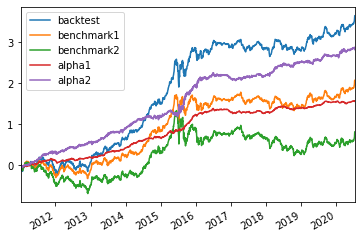

In [1474]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q = 1 - 20 / len(y_hat.columns)
position = (y_hat.gt(y_hat.quantile(q, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [1473]:
position.sum(1)

2011-01-04     0
2011-01-05    12
2011-01-06    12
2011-01-07    12
2011-01-10    12
              ..
2020-07-10    18
2020-07-13    18
2020-07-14    18
2020-07-15    18
2020-07-16    18
Length: 2318, dtype: int64

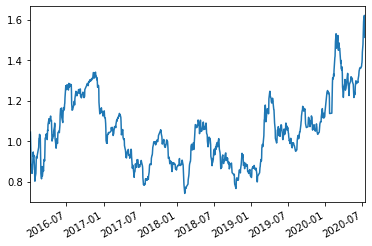

In [1405]:
(ror_huice.mean(1)-0.0008+1).cumprod().plot()

In [1382]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300209.SZ    0.192616
300803.SZ    0.154640
600855.SH    0.145568
300687.SZ    0.141097
300368.SZ    0.139459
300465.SZ    0.131158
300448.SZ    0.117734
300541.SZ    0.115167
300277.SZ    0.107636
300248.SZ    0.106496
Name: 2020-07-16 00:00:00, dtype: float64


In [465]:
df_train = df_train.dropna()
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

array([0.05159753, 0.05007378, 0.04443164, 0.04619165, 0.04480049,
       0.04128151, 0.04127881, 0.05454827, 0.05270984, 0.05264996,
       0.04963717, 0.05406033, 0.04655707, 0.04854932, 0.0502602 ,
       0.0494474 , 0.04531465, 0.04479211, 0.04590302, 0.0421521 ,
       0.04376315])